# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
**Actividad Curvas ROC y PR**


# **Itroducción**

La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

El archivo de los datos está en Canvas y se llama "oil-spill.csv".


En la siguiente liga se encuentra la liga del artículo relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico. La última columna es de valor 1 (hay derrame en esa sección de la imagen) o 0 (no hay derrame en esa sección de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

En la siguiente liga puedes encontrar información de varias de las métricas que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La media geométrica se puede obtener combinando las métricas anteriores, pero para fines prácticos usaremos la de la librería llamada "imbalanced-learn":

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

In [23]:
# Incluye todas las librerías que consideres adecuadas:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para fines de la actividad procesaremos los datos de manera estándar para concentrarnos en los temas de la actividad.

In [2]:
path = '/content/drive/MyDrive/IAAyAA/Semana4/oil_spill.csv'
df = read_csv(path, header=None)   # no tienen nombre las columnas

print('Timensión del DataFrame',df.shape)

# eliminamos las siguientes columnas:
df.drop(22, axis=1, inplace=True)    # Esta columna tiene un solo valor constante.
df.drop(0, axis=1, inplace=True)     # Esta columna contiene información de secciones (batches) de las imágenes, que no la requerimos.

df.columns = [i for i in range(df.shape[1])]   # Renombramos las columnas para que sean enteros consecutivos.

# Particionamos los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)
print('\nPartición:')
print('Train: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytrain.sum(), 100*(ytrain.sum() / len(ytrain))))
print('Val: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (yval.sum(), 100*(yval.sum() / len(yval))))
print('Test: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytest.sum(), 100*(ytest.sum() / len(ytest))))

Timensión del DataFrame (937, 50)

Partición:
Train: Conteo clase positiva=29, Porcentaje=4.40%
Val: Conteo clase positiva=7, Porcentaje=4.24%
Test: Conteo clase positiva=5, Porcentaje=4.42%


Breve descripción numérica y gráfica del conjunto de entrenamiento:

In [3]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


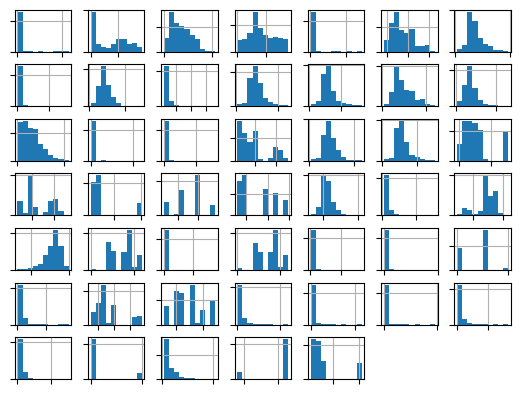

In [4]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()

In [5]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

In [6]:
# Código-1:
# Aplicamos la función Dummy:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, modeloD)

print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (np.nanmean(scores), np.nanstd(scores)))

Métrica G-mean - Media Geométrica: 0.457 (0.184)


# **Ejercicio-1**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como lo que significa el valor que se obtiene en su salida:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



1.   Elemento de lista
2.   Elemento de lista
3.   Elemento de lista
4.   Elemento de lista
5.   Elemento de lista
6.   Elemento de lista
7.   Elemento de lista
8.   Elemento de lista
9.   Significado del valor de salida:




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos:

In [7]:
# Transforamaciones numéricas:

numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('std_transformer', StandardScaler())])
numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [8]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.951 (0.015)
G-mean: >> 0.753 (0.079)

LASSO
Exactitud: >> 0.968 (0.009)
G-mean: >> 0.689 (0.104)

RIDGE
Exactitud: >> 0.969 (0.011)
G-mean: >> 0.725 (0.108)

EN
Exactitud: >> 0.968 (0.010)
G-mean: >> 0.694 (0.112)

kNN
Exactitud: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



<ipython-input-9-0db74e03d2d4>:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados1, labels=nombres,  showmeans=True)


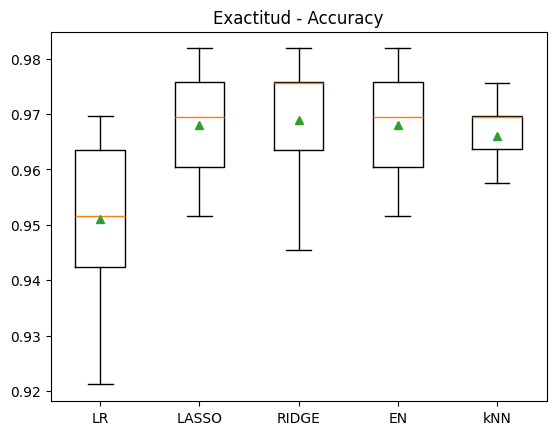

<ipython-input-9-0db74e03d2d4>:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados2, labels=nombres,  showmeans=True)


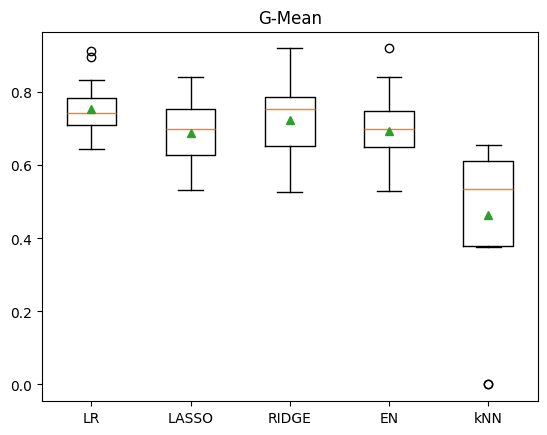

In [9]:
# Código-2:
# ACCURACY & G-mean

def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-2**

### **Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



None




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-3**

### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una función llamada "mis_modelos2()" y utilízala para definir los mismos modelos de regresión logística, pero incluyendo el argumento class_weight='balanced'. Los demás hiperparámetros los puedes variar si así lo consideras adecuado. Incluye kNN, aunque no tiene argumento para balanceo de las clases de salida.**

Resultados de Validación:
LR
G-mean: >> 0.753 (0.079)

LASSO
G-mean: >> 0.689 (0.104)

RIDGE
G-mean: >> 0.725 (0.108)

EN
G-mean: >> 0.694 (0.112)

kNN
G-mean: >> 0.464 (0.204)



<ipython-input-12-1293f3fa9f31>:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados2, labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.


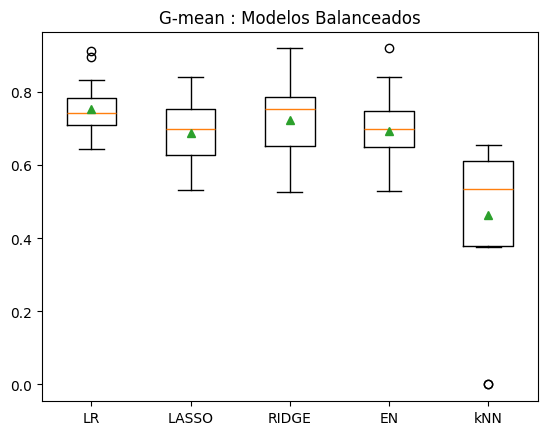

In [12]:
#  Casos balancedos con hiperparámetro de Regresión Logística:

# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

# Código-2:
# G-mean

def mis_modelos2():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

modelos, nombres2 = mis_modelos2()
resultados2 = list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'m_geo':mi_metrica},
                          cv=cv1)

  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++


plt.boxplot(resultados2, labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.
plt.title("G-mean : Modelos Balanceados")
plt.show()

# **Ejercicio-4**

### **4a) Selecciona el que consideres sea el mejor modelo encontrado hasta ahora y utilízalo para obtener los gráficos curva-ROC y curva-PR, así como los valores de sus áreas bajo la curva. Sigue utilizando los conjuntos de entrenamiento y validación.**



In [21]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

# +++++++++ Inicia sección para incluir tu código ++++++++++++++++++++++++

modelo = LogisticRegression(penalty=None, max_iter=4000, random_state=1)

dicc_grid = {'C':[i/5 for i in range(1,3)]
             }

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state=1)

grid = GridSearchCV(estimator=modelo,
                    param_grid=dicc_grid,
                    cv=cv,
                    scoring=mi_metrica,
                    n_jobs=-1,
                    return_train_score=True
                    )

Xx = columnasTransformer.fit_transform(Xtv)

grid_result = grid.fit(Xx, np.ravel(ytv))

#mejor_modelo = None


# +++++++++ Termina sección para incluir tu código ++++++++++++++++++++++++

print("Mejor modelo: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
print('Promedios Train mean(std): %.4f(%.4f)' % (np.nanmean(grid_result.cv_results_['mean_train_score']),
                                                 np.nanmean(grid_result.cv_results_['std_train_score'])))
print('Promedios Val mean(std): %.4f(%.4f)' % (grid_result.cv_results_['mean_test_score'].mean(),
                                               grid_result.cv_results_['std_test_score'].mean()))



# **+++++++++++ Termina sección para agregar código ++++++++++++++**

Mejor modelo: 0.744621 usando {'C': 0.2}
Promedios Train mean(std): 1.0000(0.0000)
Promedios Val mean(std): 0.7446(0.0735)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


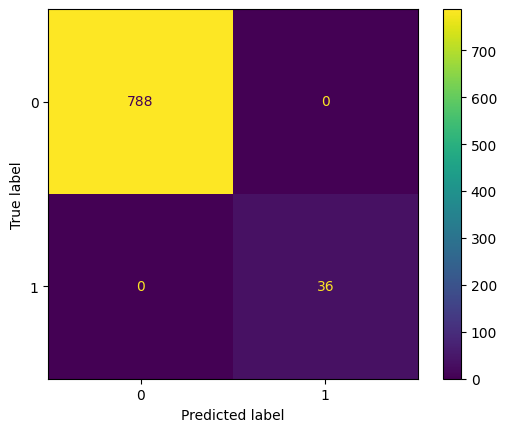

In [24]:
#Obtención de matriz de confución
modelo_mejor = LogisticRegression(penalty=None,
                                  max_iter=4000,
                                  C=0.2,
                                  random_state=1)

Xx = columnasTransformer.fit_transform(Xtv)

mejor_result = modelo_mejor.fit(Xx, np.ravel(ytv))

# oheTest=OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
# yTestOhe = oheTest.fit_transform(ytest)

mejor_result.score(columnasTransformer.transform(Xtest), ytest)

ConfusionMatrixDisplay.from_estimator(mejor_result, Xx, np.ravel(ytv))
plt.show()

### **4b) Incluye tus conclusiones de los gráficos obtenidos en el inciso anterior.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



None




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-5**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido.**

In [ ]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.



None




# **+++++++++++ Termina sección para agregar código ++++++++++++++**

# **Ejercicio-6**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



None




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

## **<<< Fin de la Actividad de la Semana - curvas ROC y PR >>>**